# Twitter Sentiment EDA

In this notebook we will take a closer look at the Twitter Sentiment Extraction dataset by Kaggle, found here: https://www.kaggle.com/c/tweet-sentiment-extraction/overview. Through varying plots and visualizations we will attempt to get a better view/understanding of this data, including but not limited to the distribution of words/phrases charged with sentiment, similarities between whole texts and selected sections which contain sentiment, as well as most commonly appearing words/ most emotionally charged words.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv


In [3]:
#Loading data
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
ss = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [4]:
#drop null values since they are of no use
train.dropna(inplace=True)

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [6]:
#Looking at our data
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,8169cd1509,Has finally found her new flat.,good,neutral
freq,1,1,199,11117


### Isolating different sentiments
We'll begin by grouping our data according to the three different sentiments that exist: positive, negative and neutral. We'll then vizualize the amount of these different sentiments within our dataset


In [8]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<AxesSubplot:xlabel='sentiment', ylabel='count'>

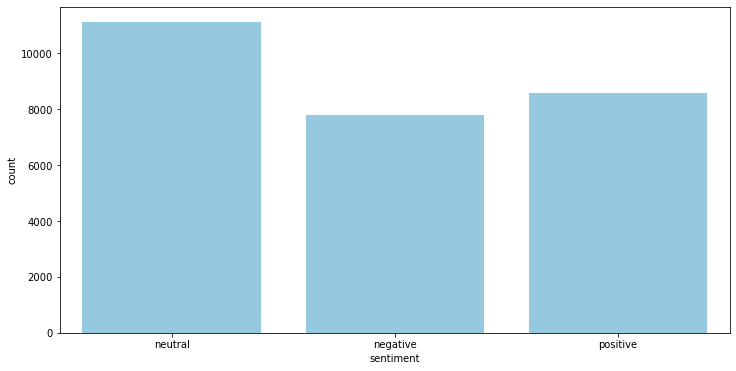

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train, color='skyblue')

### Quantifying selected text/ text (both in terms of no of words and no of characters)
Next, we will create new columns for the size of our text and selected text in terms of length of words and characters. This will be useful to us in future computations/vizualizations.

In [10]:

train['textW'] = train['text'].apply(lambda x: len(x.split()))
train['selTextW'] = train['selected_text'].apply(lambda x: len(x.split()))
train['textC'] = train['text'].apply(lambda x: len([h for h in x if h !=' ']))
train['selTextC'] = train['selected_text'].apply(lambda x: len([h for h in x if h != ' ']))
train

,textID,text,selected_text,sentiment,textW,selTextW,textC,selTextC
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,29,29
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,36,7
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,21,10
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3,26,12
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,61,11
...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16,2,60,5
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23,3,97,11
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22,6,88,20
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6,6,20,20


### Using jaccard similarity to measure similarity between whole text/selected text (both for words and characters)
Using the concept of jaccard similarity, I will measure the similarity between our given texts and their corresponding selected texts. This is essentially useful in the sense of understanding the proportion of our given texts that are emotionally charged for their respective sentiments


In [11]:
def jaccard_sim_words(a,b):
    s1 = set(a.split())
    s2 = set(b.split())
    s3 = s1.intersection(s2)
    
    return len(s3)/(len(s1) + len(s2) - len(s3))

def jaccard_sim_chars(a,b):
    s1 = set([h for h in a])
    s2 = set([h for h in b])
    s3 = s1.intersection(s2)
    
    return len(s3)/(len(s1) + len(s2) - len(s3))

In [12]:
jaccard_words = []
jaccard_chars = []

for i, j in train.iterrows():
    
    jaccard_words.append([j.text, j.selected_text, jaccard_sim_words(j.text, j.selected_text)])
    jaccard_chars.append([j.text, j.selected_text, jaccard_sim_chars(j.text, j.selected_text)])
    

jcw = pd.DataFrame(jaccard_words, columns=['text', 'selected_text', 'jac_sim_words'])
jcw['jac_sim_chars'] = jaccard_chars
jcw['jac_sim_chars'] = jcw['jac_sim_chars'].apply(lambda x : x[2])
train = train.merge(jcw, how='outer')
train


,textID,text,selected_text,sentiment,textW,selTextW,textC,selTextC,jac_sim_words,jac_sim_chars
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,29,29,1.000000,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,36,7,0.200000,0.250000
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,21,10,0.166667,0.769231
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3,26,12,0.600000,0.571429
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,61,11,0.214286,0.333333
...,...,...,...,...,...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16,2,60,5,0.058824,0.272727
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23,3,97,11,0.083333,0.366667
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22,6,88,20,0.272727,0.500000
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6,6,20,20,1.000000,1.000000


### Plotting distribution of text/selected text in terms of words and characters
Using our earlier computations, we will now plot the distribution of both our texts and selected texts in terms of their length in words and characters.

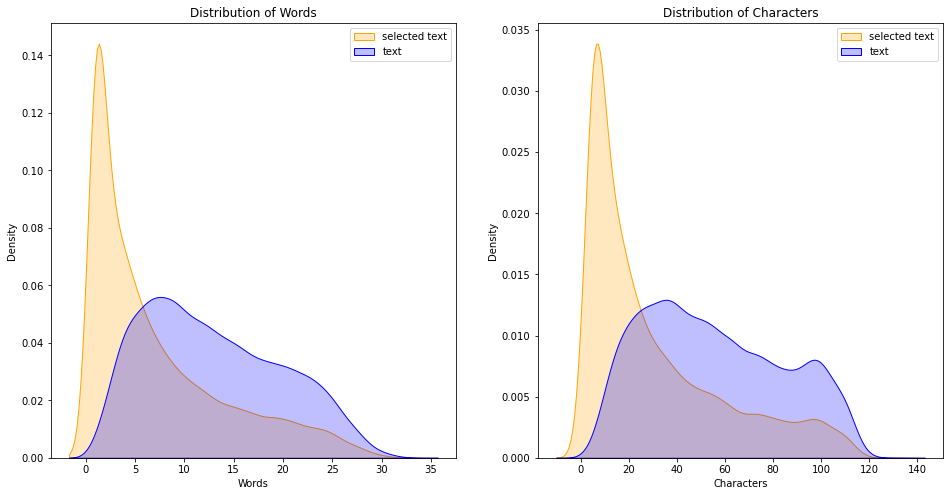

In [13]:
a,b = plt.subplots(1,2, figsize=(16,8))
sns.kdeplot(train['selTextC'], ax = b[1], color='orange', fill=True, label='selected text')
sns.kdeplot(train['textC'], ax = b[1], color='blue', fill=True, label='text')
sns.kdeplot(train['selTextW'], ax = b[0], color='orange', fill=True, label='selected text')
sns.kdeplot(train['textW'], ax = b[0], color='blue', fill=True, label='text')

b[1].title.set_text('Distribution of Characters')
b[1].set(xlabel='Characters')
b[1].legend()
b[0].title.set_text('Distribution of Words')
b[0].set(xlabel='Words')
b[0].legend()

From these vizualizations, we can see that our selected text, in contrast to our whole text,seems to be significantly smaller in length on average, for both words and characters

### Plotting correlation between text/selected text and jaccard similarity in terms of words and characters 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


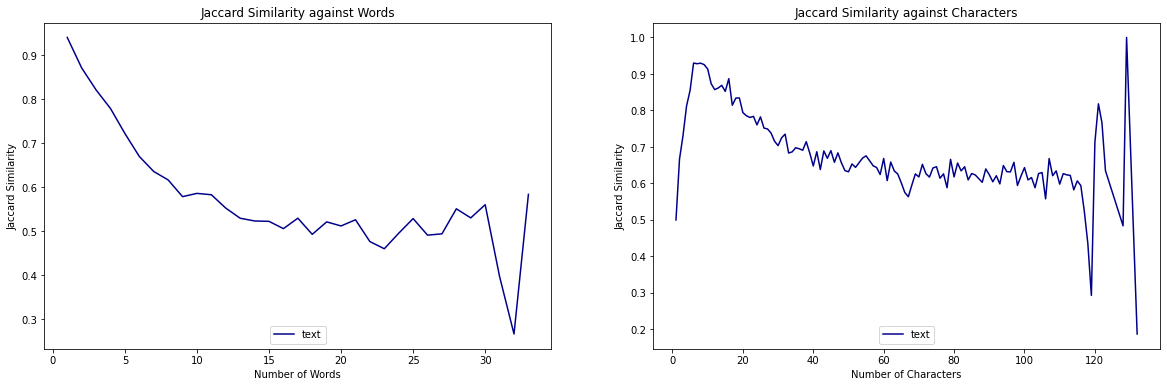

In [14]:
a,b = plt.subplots(1,2, figsize=(20,6))
g = train.groupby('textW', as_index=False).mean()[['textW', 'jac_sim_words']]
h = train.groupby('selTextW', as_index=False).mean()[['selTextW', 'jac_sim_words']]
i = train.groupby('textC', as_index=False).mean()[['textC', 'jac_sim_chars']]
j = train.groupby('selTextC', as_index=False).mean()[['selTextC', 'jac_sim_chars']]

sns.lineplot(g['textW'], g['jac_sim_words'], color='darkblue', ax=b[0], label='text')
#sns.lineplot(h['selTextW'], h['jac_sim_words'], color='blue', ax=b[0], label='selected text')
sns.lineplot(i['textC'], i['jac_sim_chars'], color='darkblue', ax=b[1], label='text')
#sns.lineplot(j['selTextC'], j['jac_sim_chars'], color='blue', ax=b[1], label='selected text')

b[0].set_xlabel('Number of Words')
b[0].set_ylabel('Jaccard Similarity')
b[0].legend(loc = 'lower center')
b[1].set_xlabel('Number of Characters')
b[1].set_ylabel('Jaccard Similarity')
b[1].legend(loc = 'lower center')
b[0].title.set_text('Jaccard Similarity against Words')
b[1].title.set_text('Jaccard Similarity against Characters')

Here we can see that text size seems to correlate negatively with jaccard similarity, which is to say that larger text samples seem to contain smaller proportions of emotionally charged content

### Taking a look at the most commonly occuring words for each sentiment
Now we will look at individual words within our dataset. In order to do so we will tokenize text from each row of our selected column, and then remove words which can be found in nltk's stopwords list, since these words might be common but do not add significant meaning to our text

In [15]:
from nltk.corpus import stopwords
import string
from collections import Counter 
from wordcloud import WordCloud
nltk.download('stopwords')
stopwords = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def tokenize_content(content):
    l = []
    for nm in content:
        n = nltk.word_tokenize(nm)
        for np in n:
            np = np.lower()
            if np not in stopwords:
                k = True
                for j in np:
                    if j not in string.ascii_letters:
                        k = False
                if k:
                    l.append(np)
        
    return l

In [17]:
neutral_selText = [t for t in train[train['sentiment'] == 'neutral']['selected_text']]
positive_selText = [t for t in train[train['sentiment'] == 'positive']['selected_text']]
negative_selText = [t for t in train[train['sentiment'] == 'negative']['selected_text']]

Then we will count the frequency of these words based on their respective sentiments, and take a look at some of the most common words based on sentiment, before visualizing them with a wordcloud!

In [18]:
positive_word_count = Counter(tokenize_content(positive_selText))
negative_word_count = Counter(tokenize_content(negative_selText))
neutral_word_count = Counter(tokenize_content(neutral_selText))

### Positive Words

In [19]:
common_positive = pd.Series(positive_word_count, name = 'freq').reset_index().\
sort_values(by='freq', ascending = False)
common_positive

,index,freq
52,good,821
16,happy,728
20,love,695
32,day,452
42,thanks,439
...,...,...
1856,points,1
1857,quiz,1
1858,goat,1
1859,prizes,1


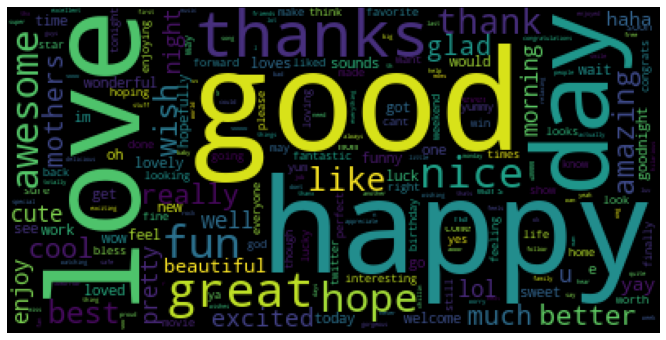

In [20]:
highest_wordcloud = WordCloud().generate_from_frequencies(positive_word_count)
plt.figure(figsize=(12,6))
plt.imshow(highest_wordcloud)
plt.axis('off')
plt.show()

### Negative Words

In [21]:
common_negative = pd.Series(negative_word_count, name = 'freq').reset_index().\
sort_values(by='freq', ascending = False)
common_negative

,index,freq
22,miss,359
1,sad,332
13,sorry,293
75,bad,240
63,hate,230
...,...,...
2228,mortified,1
2231,fickleness,1
2234,losers,1
2235,via,1


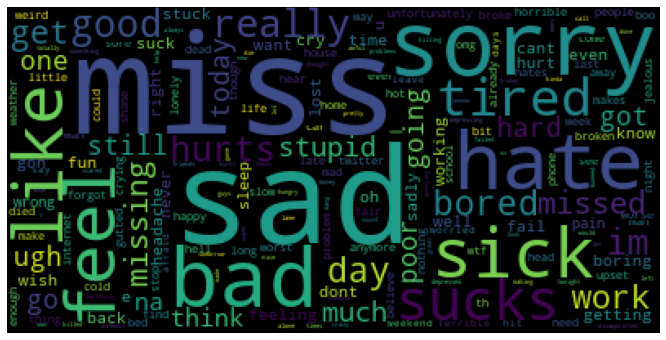

In [22]:
highest_wordcloud = WordCloud().generate_from_frequencies(negative_word_count)
plt.figure(figsize=(12,6))
plt.imshow(highest_wordcloud)
plt.axis('off')
plt.show()

### Neutral Words

In [23]:
common_neutral = pd.Series(Counter(tokenize_content(neutral_selText)), name = 'freq').reset_index().\
sort_values(by='freq', ascending = False)
common_neutral

,index,freq
20,get,614
243,go,568
37,got,521
301,day,495
147,work,473
...,...,...
6635,sakura,1
6633,tres,1
6632,qs,1
6631,siky,1


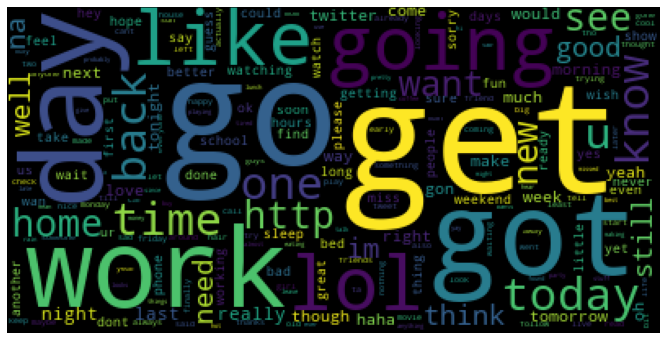

In [24]:
highest_wordcloud = WordCloud().generate_from_frequencies(neutral_word_count)
plt.figure(figsize=(12,6))
plt.imshow(highest_wordcloud)
plt.axis('off')
plt.show()